# Markdown Syntax

- [Markdown 문법](https://velog.io/@wonhs717/%EB%A7%88%ED%81%AC%EB%8B%A4%EC%9A%B4Markdown-%EB%AC%B8%EB%B2%95-ytk5zemk0x)
- [Markdown 사용법 총정리](https://heropy.blog/2017/09/30/markdown/)

# Allocation of GPU<br>

## 하나의 GPU 할당 방법

```python
    with tf.device('/gpu:1'):
         ### model = ... (model를 만들어서 compile하고 fit 해주면 됨) 
```
---

## 여러개의 GPU 할당 방법 ([참고])(https://ahnjg.tistory.com/34)
```python 
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2", "/gpu:3"])
    with strategy.scope():
        ### model = ... (model를 만들어서 compile하고 fit 해주면 됨) 
```
---

## GPU memory 확인법 
- jupyter notebook에서 command line 실행 or **terminal**로 실행(추천)
```python
    !nvidia-smi
```
  - 실시간 모니터링법: 
  > $ watch -n 0.1 nvidia-smi
  

## multi-GPU 사용 setting  ([참고](https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth))

- 그냥 MirroredStrategy 써서 바로 scope() 안에서 모델을 돌리면 tf는 GPU의 거의 모든 memory를 mapping
  - 한번에 전체를 지니고 안에서 필요한 부분을 할당해서 쓰는 느낌 -> memory fregmentation을 최소화 할 수 있음
  - 그러나 tf의 특성상 gpu:2, gpu:3을 써도 gpu:0을 거치는 것 같아서 gpu:0을 전부 쓰고 있으면 나머지 gpu를 따로 사용할 때 접근에서 문제가 생기는 것 같음 (Error 문구: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize)
  - 그래서 아래와 같이 tf가 gpu에서 처음 지정한 메모리만큼 사용하게 하거나 필요한만큼만 계속 늘려서 갖다 쓰게 하니 해결됨


- 주의사항: 아래 방법을 쓸 때, gpu 돌리기 전에 먼저 해야함. 즉 gpu 세팅해서 모델을 돌리기 전에 설정을 해야 함(아니면 initialized 후에 modify할 수 없다고 뜸 -> 그럴땐 kernel를 restart에서 다시 실행). 설정은 각 쥬피터 노트북마다 매번할때 각각 해줘야 함

<br>

### tf가 특정 gpu만 접근하도록 하기

```python
import tensorflow as tf 
 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 1, 2번째 GPU만 사용하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0:2], 'GPU')
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)
```

<br>

### tf가 접근하는 gpu의 memory 용량 제한 (ex. 4GB)

```python
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
        tf.config.experimental.set_virtual_device_configuration(gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)
```
  - 단점: 모델의 구조가 커서 텐서에 저장해야 될 메모리가 많을 경우, allocation 에러 뜸

<br>

### tf가 필요한 만큼만 계속 갖다 쓰게 하기 (추천)

```python
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
```

## GPU 메모리 비우는 방법

- GPU를 돌린 해당 커널을 종료


- container exit 했다가 다시 start, attach (가장 확실)


- tf에서 session 연 후에는 항상 닫아주기
  - keras.model.fit을 하면 session이 열리므로 train이 끝난 후에 session을 닫아줘야 함
```python
from keras import backend as K
K.clear_session()
```

<br>

- 특정 GPU 메모리 relase (확실!) 
  - Tensorflow is just allocating memory to the GPU, while CUDA is responsible for managing the GPU memory.
If CUDA somehow refuses to release the GPU memory after you have cleared all the graph with K.clear_session(), then you can use the cuda library to have a direct control on CUDA to clear up GPU memory. ([링크](https://stackoverflow.com/questions/51005147/keras-release-memory-after-finish-training-process/52354943))

```python
from numba import cuda
cuda.select_device(2) # GPU 2번을 끌때
cuda.close()
```

<br>

- numba 모듈 이용 : 비우는 것 같은데 확실히 잘 작동하는지는 모르겠음

```python
from numba import cuda 
device = cuda.get_current_device()
device.reset()
```


- sudo nvidia-smi --gpu-reset –i gpuID : 강제로 gpu memory 지우기
(or sudo nvidia-smi –r) <br>
cf) ‘GPU Reset couldn't run because GPU0 is the primary GPU’ 라는 에러 문구 뜨면 sudo rmmod nvidia_uvm으로 해결가능하나 물리적인 재부팅이 제일 확실하고 좋은 방법


- 최후의 수단: linux restart(재부팅)

# 환경 세팅


## Docker
- [Tensorflow와 호환되는 CUDA, cuDNN 설치하는 법](https://coding-groot.tistory.com/87)
  - 또는 리눅스에서 docker(또는 window)를 사용하는 경우, [docker hub](https://hub.docker.com/r/nvidia/cuda/)에서 필요한 버전이 담긴 nvidia/cuda image을 다운받아 container를 만들면 됨


- 자세한 내용은 구글독 문서 (docker 사용법.docs) 참조

- [Anaconda 가상환경 설치](https://kyumdoctor.tistory.com/26)


## SSH tunneling
- [SSH tunneling - the black magic for data science](https://medium.com/hackernoon/the-ssh-black-magic-for-data-science-acd6f65e8528) <br>

(tunnelssh) <br>
ssh -o ExitOnForwardFailure=yes -N -R *:8000:localhost:8888 -i pivr.pem -o StrictHostKeyChecking=no pivr@54.180.210.78 
<br>

(.ssh) <br>
known_hosts
<br>
tunnel-pivr.pem

## Jupyterlab

* [참고 블로그](https://onesixx.com/jupyter-lab/)

### execute time 사용하기
1. terminal에서 conda actiavte (가상환경)
2. 해당 가상환경으로 들어갔으면, conda install -c conda-forge jupyterlab_execute_time 후 y
3. 설치 후, settings -> advanced settings editor 에서 user preferences 에다가 아래 입력 후 저장
{
    "recordTiming": true
}


### CPU & Memory 모니터링
* [참고 블로그](https://ebbnflow.tistory.com/329)


# Keras.model

## Keras 모델 저장 및 불러오기

- **모델의 아키텍처 및 구조 저장:**   model.to_json()으로 모델의 구조 정보를 가져오고'model.json' 형태로 저장 후 model_from_json으로 불러오기
- **모델의 weights 저장:** 'weights.hdf5' 형태로 저장하고 model.load_weights(weight_path)로 불러오기 <br><br>
- **모델의 모든 정보 저장:** [Keras 모델 저장 및 로드](https://www.tensorflow.org/guide/keras/save_and_serialize?hl=ko) <br>
 -- model.save()로 저장하면 폴더를 생성함 - 모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb에 저장됩니다. 가중치는 variables/ 디렉토리에 저장 <br>
 -- tf.keras.models.save_model()로 'model.h5' 형태로 저장 후 tf.keras.models.load_model()로  불러옴. 


## Keras validation split

- keras.model의 fit함수에서 shuffle=True는 매 epoch마다 training set를 shuffle하는 것이고, validation_split=0.1을 하면 처음 주어진 training set에서 뒤에 10%를 순서대로 뽑아 validation set으로 처리한다. 따라서 fit하기 전에 따로 training set를 random하게 shuffle해야 한다.

- train의 x값과 y값의 shuffle은 아래와 같이 하면 된다.

```python
    ids = np.arange(x_train.shape[0])
    np.random.shuffle(ids)

    x_train = x_train[ids]
    y_train = y_train[ids]
    y_train_bin = y_train_bin[ids]
```

- 그러나, **각 환자마다 data augmentation이 많이 되었으면** test set 나누듯이 validation도 train set 내에서 환자 caseid 단위로 나눠야함 **(중요!!!!!)**

## Keras model class API
- [Model](https://keras.io/ko/models/model/)
- [Optimizer](https://keras.io/ko/optimizers/)
- [Losses](https://keras.io/ko/losses/)
- [Regression metrics](https://keras.io/api/metrics/regression_metrics/) : y_pred와 y_test 사이의 mse나 compile API()에서의 사용법까지 잘 나와 있음

## Keras.model 그리기

- [Model plotting utilities](https://keras.io/api/utils/model_plotting_utils/)

```python
    tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
```

---

- ..
 - required: pydot, anaconda, graphviz를 설치하고 안될 경우 path 설정까지

## 원하는 layer의 output 구하기
- [Keras, How to get the output of each layer?](https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer)

```python
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions

# Testing
test = np.random.random(input_shape)[np.newaxis,...]
layer_outs = [func([test]) for func in functors]
```


## keras.backend

```python
from keras import backend as K

K.int_shape(inp) # return shape of input or output
K.function([inp], [model.layers[1].output, model.layers[-1].output]) # 이처럼 초기 input을 넣어주면 원하는 layer의 output 계산
```

# CNN Model

## [tensorflow/models](https://github.com/tensorflow/models/tree/master/research)

##  global max pooling layer:  [StackExchange Link]('https://stats.stackexchange.com/questions/257321/what-is-global-max-pooling-layer-and-what-is-its-advantage-over-maxpooling-layer')
<Blockquote> 
As described in this paper that proposed global average pooling (GAP): <br><br>
Conventional convolutional neural networks perform convolution in the lower layers of the network. For classification, the feature maps of the last convolutional layer are vectorized and fed into fully connected layers followed by a softmax logistic regression layer. This structure bridges the convolutional structure with traditional neural network classifiers. It treats the convolutional layers as feature extractors, and the resulting feature is classified in a traditional way. <br><br>
However, the fully connected layers are prone to overfitting, thus hampering the generalization ability of the overall network. Dropout is proposed by Hinton et al as a regularizer which randomly sets half of the activations to the fully connected layers to zero during training. It has improved the generalization ability and largely prevents overfitting. <br><br>
In this paper, we propose another strategy called global average pooling to replace the traditional fully connected layers in CNN. The idea is to generate one feature map for each corresponding category of the classification task in the last mlpconv layer. Instead of adding fully connected layers on top of the feature maps, we take the average of each feature map, and the resulting vector is fed directly into the softmax layer. One advantage of global average pooling over the fully connected layers is that it is more native to the convolution structure by enforcing correspondences between feature maps and categories. Thus the feature maps can be easily interpreted as categories confidence maps. Another advantage is that there is no parameter to optimize in the global average pooling thus overfitting is avoided at this layer. Futhermore, global average pooling sums out the spatial information, thus it is more robust to spatial translations of the input. We can see global average pooling as a structural regularizer that explicitly enforces feature maps to be confidence maps of concepts (categories). This is made possible by the mlpconv layers, as they makes better approximation to the confidence maps than GLMs.
</Blockquote>


- [Max poolling, average pooling](https://www.machinecurve.com/index.php/2020/01/30/what-are-max-pooling-average-pooling-global-max-pooling-and-global-average-pooling/#how-max-pooling-benefits-translation-invariance)

## Inception
- [Inception(GoogLeNet)](https://kangbk0120.github.io/articles/2018-01/inception-googlenet-review)

- [CNN의 발자취](https://m.blog.naver.com/PostView.nhn?blogId=kmkim1222&logNo=221524681282&proxyReferer=https:%2F%2Fwww.google.com%2F)
  - Inception v1: 1x1 conv layer이 소개되며 네트워크 성능을 크게 저하시키지 않으면서 매개변수의 수를 감소시킬 수 있음
  - Inception v2: prelayer + inception layer(network in network) + global average pooling + auxillary classifier + convolution factorization + batch normalization
  - Inception v3: googlenet이라고 불리며 더 발전시킴
  - Inception ResnetV2: Inception model과 Resnet model의 장점을 합침. 메모리와 연산 비용이 v3보다 2배 더 들지만
  
- [Short history of the inception](https://nicolovaligi.com/history-inception-deep-learning-architecture.html): inception v3 논문

- [Inception modules: explained and implementated](https://hacktildawn.com/2016/09/25/inception-modules-explained-and-implemented/): 아주 잘 정리되어 있는 글

- [Inception V3: Transfer Learning](https://jsideas.net/Inception_v3_transfer_learning/)

- [구글 인셉션(GoogleNet) 알아보기](https://ikkison.tistory.com/86)

## non-local neural network
- [논문정리](https://velog.io/@haejoo/Non-Local-Neural-Networks-%EB%85%BC%EB%AC%B8-%EC%A0%95%EB%A6%AC)

## Object Detection

- [Fast R-CNN](https://ganghee-lee.tistory.com/36?category=863370)
- [RCNN 부터 Mask R-CNN까지 (1) R-CNN ~ Fast R-CNN](https://woosikyang.github.io/fast-rcnn.html)
  - [Region Proposal Network (RPN) — Backbone of Faster R-CNN](https://medium.com/egen/region-proposal-network-rpn-backbone-of-faster-r-cnn-4a744a38d7f9)

# RNN

## LSTM

- LSTM cell in keras.layers.LSTM
  - return_state = True를 하면
    - [Return sequences and return states](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/)

# Training

## Underfitting

- 학습이 안되는 경우, 여러가지 원인이 있음. 주로 gradient vanishing이나 exploding과 관련
1. Activation Function: 예를 들어 CNN에서 ReLU를 쓰면 음수인 값은 0이기에 처음에 강한 negative weight이 걸리면 계속 0이 되어 학습x
  - 참고: [Using Leaky ReLU](https://www.machinecurve.com/index.php/2019/11/12/using-leaky-relu-with-keras/)
2. Input의 normalization: normalize 되지 않아 큰 값이 들어오면 학습 초기 구간에서 특정 gradient에 과부하가 걸릴 수도


## Regularization
- overfitting을 막기 위한 방법

### Dropout

### L2 loss (Weight Decay)
- [Regularization - 라온피플](https://m.blog.naver.com/laonple/220527647084)
- [How to Use Weight Decay to Reduce Overfitting of Neural Network in Keras](https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/) : 코드도 잘 정리되어 있고 많은 논문들의 예시도 담고 있음

### Batch Normalizaion
- [Batch Normalization 설명 및 구현](https://shuuki4.wordpress.com/2016/01/13/batch-normalization-%EC%84%A4%EB%AA%85-%EB%B0%8F-%EA%B5%AC%ED%98%84/)

## Optimizer

- 원래는 Aadm을 많이 썼는데 regularization을 잘 시키는 새로운 optimizer들이 나옴

### AdamW ([참고](https://hiddenbeginner.github.io/deeplearning/paperreview/2019/12/29/paper_review_AdamW.html))
  - 코드
  ```python
    import tensorflow_addons as tfa
    tfa.optimizers.AdamW(learning_rate=0.001, scedule)
```
  - [참고2](https://github.com/OverLordGoldDragon/keras-adamw) : 추천 - !pip install keras-adamw 해서 사용하면 됨


- learning rate schedular를 keras.model.fit의 callbacks=[callbacks]로 대입 ([참고1](https://stackoverflow.com/questions/60029027/decay-parameter-of-adam-optimizer-in-keras), [참고2](https://dodonam.tistory.com/178))

```python
from keras.callbacks import LearningRateScheduler
def decay_schedule(epoch, lr):
    # decay by 0.1 every 5 epochs; use `% 1` to decay after each epoch
    if (epoch % 5 == 0) and (epoch != 0):
        lr = lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(decay_schedule)
model.fit(x, y, epochs=50, callbacks=[lr_scheduler])

```

### RAdam
- [radam 정리](https://zzaebok.github.io/deep_learning/RAdam/) : Adam의 한계점과 RAdam에 대해서
- [LiyuanLucasLiu/RAdam](https://github.com/LiyuanLucasLiu/RAdam) : RAdam 논문 저자의 githhub
- [keras 버전의 RAdam](https://github.com/CyberZHG/keras-radam)
```python
!pip install keras-rectified-adam

* 사용법
from keras_radam import RAdam

In [1]:
!pip install keras-rectified-adam

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-py3-none-any.whl size=14783 sha256=5b697f51e6263e99dc7730f6af49cc23398530b991f88a5b1805b693a71ef9a1
  Stored in directory: /root/.cache/pip/wheels/1d/49/44/913b6f7b45fa25ce170bdefe45f7d6c57eb44a20f746570659
Successfully built keras-rectified-adam
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


# 유용한 Library

## Neurokit
* 주소 : [git](https://github.com/neuropsychology/NeuroKit)
* [Extract and Visualize Individual Heartbeats](https://neuropsychology.github.io/NeuroKit/examples/ecg_heartbeats/ecg_heartbeats.html)
```python
    import neurokit2 as nk
    
    # Simulate 30 seconds of ECG Signal (recorded at 250 samples / second)
    #ecg_signal = nk.ecg_simulate(duration=30, sampling_rate=250)
    # 또는 raw ECG signal(one dimensional array or list)가 있으면 사용
    
    # Automatically process the (raw) ECG signal
    signals, info = nk.ecg_process(ecg_signal, sampling_rate=250)

    # Extract clean ECG and R-peaks location
    rpeaks = info["ECG_R_Peaks"]
    cleaned_ecg = signals["ECG_Clean"]
```

# Transfer learning

- 기존에 다른 모델에서 학습해둔 결과를 이용 -> 이 transfer learning 덕분에 cnn해서 input이 천개여도 충분히 좋은 모델이 나옴
- 그래서 이미지 관련 cnn은 훈련하기 편함

# Attention 기법

## Attension mechanism
- [어텐션 메커니즘](https://wikidocs.net/22893)
- [Attention in Neural Networks - 1. Introduction to attention mechanism](https://buomsoo-kim.github.io/attention/2020/01/01/Attention-mechanism-1.md/)


## CNN의 적용
- [BAM and CBAM](https://blog.lunit.io/2018/08/30/bam-and-cbam-self-attention-modules-for-cnn/)



# Validation

## K-fold cross validation

- K-fold cross validation은 hyperparameter를 찾기 위한 방법
- training set을 k-fold로 나눠서 형성된 k개의 (Training, Test) set를 각각 학습시켜서 accuracy를 계산
- 이렇게 결정된 hyperparameter들로 최종 모델을 만들고 다시 학습(이땐 그냥 validation을 split해서 나눠도 무방)
- 최종 성능 평가는 처음에 따로 빼둔 test set에 대해 계산
- 애초에 validation set이란 최적의 모델을 찾기 위해 만든 set이기 때문!!!
- 원래는 hyperparamter 찾을 때 k-fold 해야 하지만 이론적으로 시간이 너무 많이 소요되기에 일단 search할땐 그냥 split해서 사용하다가 잘 나온 모델들간의 선택을 할때 k-fold로 성능을 비교해서 논문에 제시해주면 됨

## Hyperparameter Optimization(Tuning)

- 대표적으로 grid search와 random search가 있음. grid search는 모든 hyperparameter 조합에 대해서 알아보는 것으로 golden standard이긴 하지만 시간이 오래 걸림. 그래서 보통 random search를 많이 함.
- 참고: [Random Search vs Grid Search](https://shwksl101.github.io/ml/dl/2019/01/30/Hyper_parameter_optimization.html)

- python은 sklearn에서 GridSearchCV와 RandomizedSearchCV를 제공
```python
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
```
 - 공식 사이트: [sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
 
- grid search나 random search를 keras model에 적용한 예시 
  - KerasClassifier 이용; [Grid 예시1](https://www.kaggle.com/arrogantlymodest/randomised-cv-search-over-keras-neural-network),   **[Random 예시1](http://ethen8181.github.io/machine-learning/keras/nn_keras_hyperparameter_tuning.html)**
    - keras로 딥러닝 모델을 짠 경우, KerasClassifier에 keras 모델을 함수 형태로 집어넣고 scikit-learn의 RandomizedSearchCV나 GridSearchCV를 이용
    - [KerasClassifier 사용 예시](https://buomsoo-kim.github.io/keras/2019/07/12/Easy-deep-learning-with-Keras-19.md/)
    - 참고로 regression은 KerasRegressor(build_fn=None, **sk_params)가 있음
    > The build_fn should construct, compile and return a Keras model, which will then be used to fit/predict. One of the following three values could be passed to build_fn:
    > 1. A function
    > 2. An instance of a class that implements the __call__ method
    > 3. None. This means you implement a class that inherits from either
KerasClassifier or KerasRegressor. The __call__ method of the present class will then be treated as the default build_fn.
...
sk_params takes both model parameters and fitting parameters. Legal model parameters are the arguments of build_fn. Note that like all other estimators in scikit-learn, build_fn should provide default values for its arguments, so that you could create the estimator without passing any values to sk_params.
  - Visualization
    - [[ Python ] Scikit-Learn Pipeline + RandomizedSearchCV + shap,eli5](https://data-newbie.tistory.com/366)
    
    
    
<br><br>
- multi-core를 사용하는 방법(training, evaluation, hyperparamter tuning) ([참고](https://machinelearningmastery.com/multi-core-machine-learning-in-python/))
  - os.cpu_count()로 사용가능한 cpu 개수 알 수 있음 (python 3.4 이상. 3.4이하에선 multiprocessing.cpu_count())
  - scikit learn의 n_jobs 인자에서 이를 결정
    - n_jobs=-1은 가능한 모든 CPU 사용
    - hyperparamter tuning할 때 searching에 multi-core 몰빵하는게 효율적
  - [tune-sklearn](https://towardsdatascience.com/5x-faster-scikit-learn-parameter-tuning-in-5-lines-of-code-be6bdd21833c)
  <br>
- 다른 방법으로 Bayesian Optimization(BO)나 Particle Swarm Optimization(PSO)이 있음
  - [Bayesian Optimization](https://blog.naver.com/PostView.nhn?blogId=dpfkdlt&logNo=221678800067&from=search&redirect=Log&widgetTypeCall=true&directAccess=false)

# Model Evaluation - Metrics

## AUPRC [링크1](https://m.blog.naver.com/sw4r/221681933731)
  - precision : positive predictive value로 TP / (TP + FP). 즉 내가 답이라고 예측한 값 중 얼마나 잘 맞추었는지
  - recall : sensitivity, true positive rate. TP / (TP + FN). 즉 실제 positive 중 얼마나 잘 예측하는지
  - F1 score : 2 x (precision x recall) / (precision + recall). 즉, preicison과 recall의 조화 평균
  - Precision-Recall curve (x축이 recall, y축이 precision)
 <br> 


## AUROC [링크1](https://riptutorial.com/ko/machine-learning/example/14446/auroc--receiver-operating-characteristic--%EA%B3%A1%EC%84%A0-%EC%95%84%EB%9E%98-%EC%98%81%EC%97%AD)
  - sensitivity : recall과 같음. TPR (true positive rate)
  - specificty : true negative rate. TN / (TN + FP)
  - roc 그릴때 y_pred순으로 나열해서 1에 가까운값부터 true면 위로, false면 우측으로 이동(즉, true->false 발생시 꺾이는점 생김)하면서 그린다
  - 만약에 roc가 한 점에서 꺾인다? => y_pred를 0 또는 1 값으로 한것으로 결과가 좋아질 수 밖에 없음. 이런 논문은 거르기


## AUROC, AUPRC 코드 (계산 및 plotting)

```python
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# y_test_bin은 0 또는 1, y_pred는 연속적인 값 (roc 그릴때 꼭 한쪽은 0 또는 1, 다른쪽은 연속이고 굳이 0~1 사이일 필요는 x)
# Model AUROC, AUPRC
false_positive_rate1, true_positive_rate1, threshold = roc_curve(y_test_bin, y_pred)
precision1, recall1, _ = precision_recall_curve(y_test_bin, y_pred)

roc_auc = auc(false_positive_rate, true_positive_rate)
prc_auc = auc(recall, precision)
print('test set auroc: {:.6f},  test set auprc: {:.6f}'.format(roc_auc, prc_auc))


# plotting auprc
fig = plt.figure(figsize=(16,8))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')

ax1.plot(false_positive_rate, true_positive_rate, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc)
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.legend(loc='lower right')

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall, precision, 'b', label='Model 1 (AUC = %0.4f)'% prc_auc)
ax2.legend(loc='lower right')
plt.show()
```

  
<br>

## Confusion matrix
<center><img src="Images/confusionMatrix.jpg" width="80%" height="80%"></center> 

### sklearn.metrics
- 그러나 sklearn.metrics의 plot_confusion_matrix는 classifier를 이용하는 경우

```python
### calculating confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_pred, sample_weight)
# y_pred는 연속적인 값이 아닌 threshold에 대해 계산. 이때 threshold는 accuracy를 최대로 하냐, sensitivity를 최대로 하냐 등 목적에 따라 다름 (ex 선별검사는 sensitivity를 최대로 하는 threshold 이용). 즉 이진분류의 경우 y_pred>thval로 넣어줘야 함
```

### scikitplot.metrics
- y_pred와 y_true만 라벨링 잘 되어있으면 multiclass에 대해서도 confusion matrix를 그려줌. 그러나 sample weight은 적용 못함

```python
### plotting confusion matrix - . 일반적으로는 아래 함수
from scikitplot.metrics import plot_confusion_matrix

# 공식문서: https://scikit-plot.readthedocs.io/en/stable/metrics.html
plot_confusion_matrix(y_true, y_pred, labels=None hide_zeros=True, title='Confusion Matrix')
```

### customized plot_confusion_matrix

```python
import itertools
import matplotlib.pyplot as plt


def cplot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(3,3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.0f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
```



## Others

- specificity : true negative rate. TN / (FP+TN)
  - [참고](https://www.healthnewsreview.org/toolkit/tips-for-understanding-studies/understanding-medical-tests-sensitivity-specificity-and-positive-predictive-value/)
    - sensitive: 실제 임신한 사람 중 임신했는지를 얼마나 잘 맞추는가
    - specific: 임신 안 한 사람 중 임신안했는지를 얼마나 잘 맞추는가
<br>

- accuracy = correct prediction / total prediction = (TP + TN) / (TP+ FP + TN + FN)


### 참고문헌
- [Evaluation Metrics](http://www.davidsbatista.net/blog/2018/08/19/NLP_Metrics/) : 각각의 개념과 unbalanced data에서 PRC가 ROC보다 좋다는 내용
- [ROC curve](https://angeloyeo.github.io/2020/08/05/ROC.html) : threshold에 관한 내용

# Binary classification

## loss

## Metrics (모델 성능 평가)

# Regression

## Loss
- mse, rmse, mae

- R2 square

## Metrics
- auroc: training 과정에서 계산되는 auroc는 0 또는 1로 이루어진 y_train_bin에 대해 계산되는 것이 아닌 0~1 사이 y_train에 대해 계산되므로 classification에서 사용하는 auroc와는 차이가 있음

# Class weight, sample weight

- [How to set sample_weight in Keras?](https://androidkt.com/set-sample-weight-in-keras/)

- data가 unbalance한 경우, 각 구간(class)마다 동일한 정도로 학습을 시키고 싶으면 sample weight을 (총합)/class의 bins로 준다

- keras.model을 fit할 때, train set와 val set에 sample weight을 줄 수 있음
  - keras.model.fit(x_train, y_train, sample_weight = train_sample_weight, validation_data = (x_val, y_val, val_sample_weight)...)
  
  


[Deep Learning With Weighted Cross Entropy Loss On Imbalanced Tabular Data Using FastAI](https://towardsdatascience.com/deep-learning-with-weighted-cross-entropy-loss-on-imbalanced-tabular-data-using-fastai-fe1c009e184c)

# Unbalanced data 다루는 법

- sample weight나 class weight을 줄 수 있음


- resampling을 함 -> 데이터수가 많으면 over-represented class에서 제거, 데이터수가 적으면 under-represented class에 sample을 추가
  - **[SMOTE (Synthetic Minority Over-sampling Technique)]**(https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a) : from imblearn.over_sampling import SMOTE

# Deep learning with noisy labels
- Davood Karimi, Haoran Dou, Simon K. Warfield, Ali Gholipour,
Deep learning with noisy labels: Exploring techniques and remedies in medical image analysis, Medical Image Analysis, Volume 65, 2020, 101759 [(논문)](https://www.sciencedirect.com/science/article/pii/S1361841520301237#bib0073)

# Unsupervised Learning

## Semi-supervised learning

- [Semi-Supervised Learning 정리](https://medium.com/@kabbi159/semi-supervised-learning-%EC%A0%95%EB%A6%AC-a7ed58a8f023) : 여러가지 semi-supervised learning의 종류 소개 및 최신 링크


## Unsupervised learning

- [How to do Unsupervised Clustering with Keras](https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/)
  - **autoencoder**: 예를 들어 encoder로 10D 짜리 feature를 만들고 이를 다시 decoder에 넣어 원래 input을 만드는 모델
  - 그 다음 이 10D 짜리 features를 K-means으로 10개의 cluster를 만듬
  - [관련 github](https://github.com/Tony607/Keras_Deep_Clustering)
  
## Autoencoder
- [variational autoencoder](https://keraskorea.github.io/posts/2018-10-23-keras_autoencoder/)
- [Convolutional Autoencoder with Keras](https://www.kaggle.com/anmour/convolutional-autoencoder-with-keras)
- [Convolutional Autoencoders for Image Noise Reduction](https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763)

### Deconvolution
- [참고](https://analysisbugs.tistory.com/104)

# Python 관련 파일 문법

## 파일 이동, 복사

```python
    # 필요한 모듈
    import shutil, os

    # 폴더의 하위 파일 이름 가져오기
    cache_path = 'cache/PPG'
    file_list = os.listdir(cache_path)

    # 파일 위치 바꾸기
    for file_name in file_list:
        if 'PACU1_12' in file_name:
            print(file_name)
            shutil.move('cache/PPG2/'+file_name, 'cache/PPG/'+file_name)

    # 파일 이름 바꾸기
    for file_name in file_list:
        if 'hbi_ppga2_' in file_name:
            mod_name = 'hbi_ppga_' +file_name[10:]
            print(file_name, '...changed')
            os.rename(os.path.join(cache_path,file_name), os.path.join(cache_path,mod_name))
            
    # 파일 복사해서 옮기기 
    shutil.copy(옮기고싶은 파일, 옮기려는 곳) # 옮기려는 곳이 디렉토리면 그 하위로, 파일이면 옮기고 싶은 파일로 대체
    shutil.cpy2( `` ) # 파일의 모든 메타 정보까지 옮김 
    
    # 하위 모든 디렉토리 접근
    os.walk 이용
```

  - [파일 복사 관련 링크](https://blog.naver.com/PostView.nhn?blogId=hankrah&logNo=221832296707&categoryNo=51&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView)
  
  - [File, directory 관련 링크](https://www.geeksforgeeks.org/python-os-listdir-method/)

## 파일 압축 하기, 풀기 ([참고](https://yganalyst.github.io/data_handling/memo_2/))

```python
    import zipfile

    # 압축 풀기
    file = zipfile.ZipFile('example.zip')
    # 전체 압축 풀기
    file.extractall() # 또는 저장될 경로 입력
    # 특정 파일 압축 풀기
    file.extract('선택할 파일', '저장할 경로')
    
    
    # 압축하기
    fzip = zipfile.ZipFile('example.zip', 'w')
    fzip.write('example.txt')
    fzip.close()
```

## 구글드라이브 통해서 파일 다운로드 하기 ([참고1](https://hmdev.vercel.app/%EA%B5%AC%EA%B8%80-%EB%93%9C%EB%9D%BC%EC%9D%B4%EB%B8%8C-%ED%8C%8C%EC%9D%BC-wget,-curl-%ED%95%98%EA%B8%B0))

* 쥬피터 셀 이용하는 방법 (gdown)
    * 구글 드라이브 파일(폴더 x)을 '링크가 있는 모든 사용자' 액서스로 공유 설정해서 링크 복사
    * 예시로 https://drive.google.com/file/d/1xaRFi3AoM7BHJ9omI-9cioS34hoKV3eU/view?usp=sharing에서 file/d/뒤에 id(1xaRFi3AoM7BHJ9omI-9cioS34hoKV3eU)를 복사
    * 아래 'https://drive.google.com/uc?id=' 뒷부분에 붙여넣기

```python
import gdown

gurl = 'https://drive.google.com/uc?id=1xaRFi3AoM7BHJ9omI-9cioS34hoKV3eU'
gdown.download(gurl, 'pacu.zip')
```
* 그러나 위 방법으로 안되는 경우들이 있음 (파일이 아닌 폴더를 공유하는 경우 -> 압축해서 해결 / 파일 크기가 너무 큰 경우 -> 쪼개서 압축 / 하루에 한 계정으로 공유를 여러번 시도하다보면 그냥 막힘...)

* [wget/curl를 이용한 방법](https://deeplify.dev/server/bash/download-google-drive-file-in-terminal)
    * curl은 큰 용량의 파일에서는 안됨
    * wget의 경우에도 마찬가지로 폴더가 아닌 파일에만 쓸 수 있고 큰 용량에 대해서도 시도 가능
    * 쥬피터 커널에 아래 명령어 입력 ({FILEID} 대신 위 fileid 대체 + {FILENAME}에 저장할 파일 이름 지정하면 됨)  
    wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILEID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILEID}" -O {FILENAME} && rm -rf ~/cookies.txt
    

# Waveform processing

- **Savitzky-Golay filter** : convolution filter를 씌움
  - scipy.signal.savgol_filter
  
  
- **Welch** : 주어진 input이 주기적으로 반복된다고 가정(여기서 퓨리에 변환의 기본 각진동수 w 획득) -> Hann filter(삼각함수 형태)를 씌워 양쪽 끝을 0으로 맞춤. 그래야 주기적으로 반복할 수 있음 -> FFT(fast fourier transform)을 적용 -> output이 복소수이고 절반은 앞의 절반이 대칭으로 반복. 즉, 우리는 크기에만 관심이 있기에 이중 절반만 관심있고 크기를 취함
  - scipy.signal.welch
  
  
- **Butterworth filter** : band pass filter
  - scipy.signal.butter
- lowpass filter
  - scipy.lfilter
  
  
- **lowess filter** : 아주 정교하지만 오래걸림. 파형의 움직임을 뽑아낼 수 있음 -> 이걸로 noise 제거해서 파형이 움직이는 변위를 없앨 수 있음

# Python graph plotting

## Plane graph

- plt.figure(figsize=(10, 5)) 를 하면 새로운 figure를 형성

- 그래프 여러개를 그리고 싶을때(예를 들어 2x2), subplots나 subplot를 이용 ([차이점](https://m.blog.naver.com/PostView.nhn?blogId=heygun&logNo=221520454294&proxyReferer=https:%2F%2Fwww.google.com%2F))

> fig, axes = subplots(nrows=2, ncols=1)

 - fig는 figure로 subplots로 소환된 그래프 전체를 지칭
 - axes는 ax들의 리스트. nrows x ncols 만큼 형성
 
> ax = subplot(2,1,1)

 - ax는 개별 figure만 지칭
 
> fig = plt.figure(figsize=(20,10)) <br>
ax1 = fig.add_subplot(2,1,1)<br>
ax1.plot(~)<br>
ax1.set_xlim, set_title 등등

 - subplot과 비슷한 방식

## [눈금(ticks) 설정](https://kongdols-room.tistory.com/84)

## Python Histogram Plotting ([Link](https://realpython.com/python-histograms/))


### bars
- 좋은 참고문헌: [막대그래프](http://hleecaster.com/python-matplotlib-bar-graph/)


### dictionary
```python
    from collections import Counter
    Counter(a) # return dictionary
``` 
<br>

### Visualization


#### **matplotlib.pyplot의 hist 함수 이용** ([**자세한 인자 사용**](https://kongdols-room.tistory.com/94))
- bins: histogram 값의 기준값 설정 (ex. [0, 1, 2, 3]으로 하면 0, 1, 2, 3에 대한 빈도를 표현함) 
    
#### pd.Series.plot.hist, pd.Series.value_counts 이용

(0.0, 80.0)

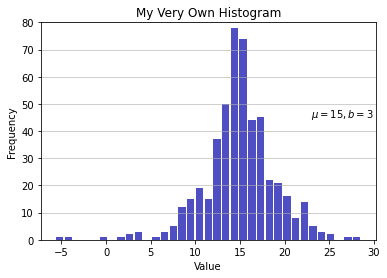

In [2]:
import matplotlib.pyplot as plt

d = np.random.laplace(loc=15, scale=3, size=500)
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=d, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

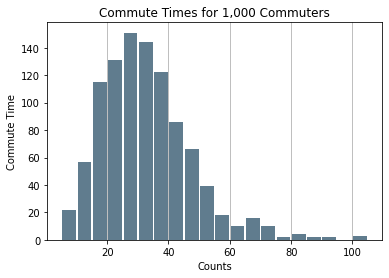

In [3]:
import pandas as pd

# Generate data on commute times.
size, scale = 1000, 10
commutes = pd.Series(np.random.gamma(scale, size=size) ** 1.5)

commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Commute Times for 1,000 Commuters')
plt.xlabel('Counts')
plt.ylabel('Commute Time')
plt.grid(axis='y', alpha=0.75)

### seaborn library 이용
* [seaborn tutorial](https://junstar92.tistory.com/90)

# Python-pptx

- [업무 자동화 - 파이썬으로 파워포인트 편집하기](https://ai-creator.tistory.com/208)
  - slide_layouts의 index: 차례대로 0부터 시작
    - Title (presentation title slide)
    - Title and Content
    - Section Header (sometimes called Segue)
    - Two Content (side by side bullet textboxes)
    - Comparison (same but additional title for each side by side content box)
    - Title Only
    - Blank
    - Content with Caption
    - Picture with Caption
   
  - matplotlib의 figure를 넘길때 fig.savefig(file_path)해서 slide.shapes.add_picture(file_path, left, top)해서 넘긴 후 os.remove(file_path)
    

# 편리한 python 문법

## Enumerate

- for 문에서 몇번째 index 돌리는지 알고 싶을때 사용
```python
    for i, element in enumerate(list_ex):
        # enumerate는 (idx 번호, 컬렉션의 원소)를 반환
```
- 첫 번째 케이스만 다르게 돌리고 싶은 경우 사용하면 좋음
```python
    for i, element in enumerate(list_ex):
        if i:
            #첫 번째 원소에 대해 처리하고 싶은 내용
```

# Watermark 모듈

[Jupyter notebook 매직 커맨드로 모듈 버전, OS 정보 등을 출력하는 watermark 모듈](https://pinkwink.kr/1235)

# 문헌 관리

- Zotero ([guide](https://www.zotero.org/support/quick_start_guide)) : google docs에서도 쓸 수 있어 편하고 좋음

# 좋은 참고사이트

- [wikidocs](https://wikidocs.net/61375)

# 의학연구에서 실수하기 쉬운 부분들

## Training set, Test set split

- 한 환자에서 여러개의 데이터를 뽑아내는 경우, 이들 전체를 shuffle해서 training, test set 나누면 안됨. 환자의 caseid 단위로 나눠야 함
  - 그냥 전체 데이터에 대해서 shuffle를 하면 한 환자에서 일부는 train, 일부는 test set에 들어가 더욱 쉽게 맞힘
  
  
- validation set도 각 환자에 대해서 augmentation이 많이 되었으면 마찬가지 이유로 환자 caseid에 대해서 나눠줘야 함 

# Unsolved Questions

1. y를 event 발생이라고 뒀을 때, non-event 사건은 얼마나 뽑아야 하는지
<br> ex) 뇌파에서 특정 spike를 detect하는데 특정 spike와  
 a) 보통은 전체 incidence 발생율 대로 나누면 되지 않을까.

- [RNN visualization](https://github.com/OverLordGoldDragon/see-rnn)